In [ ]:
from utilities.load_flight_network import load_flight_network  
from utilities.analyze_graph_features import analyze_graph_features
from utilities.create_interactive_map import create_interactive_map
from utilities.summarize_graph_features import summarize_graph_features
from utilities.getcoords import get_coordinates

import pandas as pd
import time 
import networkx as nx

In [ ]:
# Load the data
filepath = 'flight_data.csv'  # Replace with your dataset path
df = pd.read_csv(filepath)

# Identify missing coordinates for origin and destination
missing_origins = df[df["Org_airport_lat"].isna() | df["Org_airport_long"].isna()]
missing_destinations = df[df["Dest_airport_lat"].isna() | df["Dest_airport_long"].isna()]

# Get unique values for Origin and Destination airports
unique_origins = missing_origins[["Origin_city", "Origin_airport"]].drop_duplicates()
unique_destinations = missing_destinations[["Destination_city", "Destination_airport"]].drop_duplicates()

# Dictionary to cache results
coordinate_cache = {}

print("Processing unique origin airports...")
unique_origins = unique_origins.reset_index(drop=True)  # Reset index for proper tracking
total_unique_origins = len(unique_origins)
for idx, row in unique_origins.iterrows():
    airport_key = f"{row['Origin_city']}|{row['Origin_airport']}"
    if airport_key not in coordinate_cache:
        lat, lon = get_coordinates(row["Origin_city"], row["Origin_airport"])
        coordinate_cache[airport_key] = (lat, lon)
        print(f"[{idx + 1}/{total_unique_origins}] Origin Airport ({row['Origin_airport']}) in {row['Origin_city']} updated: ({lat}, {lon})")
        time.sleep(1)  # Respect API rate limits

# Process unique destination airports
print("Processing unique destination airports...")
unique_destinations = unique_destinations.reset_index(drop=True)  # Reset index for proper tracking
total_unique_destinations = len(unique_destinations)
for idx, row in unique_destinations.iterrows():
    airport_key = f"{row['Destination_city']}|{row['Destination_airport']}"
    if airport_key not in coordinate_cache:
        lat, lon = get_coordinates(row["Destination_city"], row["Destination_airport"])
        coordinate_cache[airport_key] = (lat, lon)
        print(f"[{idx + 1}/{total_unique_destinations}] Destination Airport ({row['Destination_airport']}) in {row['Destination_city']} updated: ({lat}, {lon})")
        time.sleep(1)  # Respect API rate limits

# Update the DataFrame with cached coordinates
print("Updating the DataFrame with cached coordinates...")
total_rows = len(df)
for index, row in df.iterrows():
    origin_key = f"{row['Origin_city']}|{row['Origin_airport']}"
    if origin_key in coordinate_cache:
        df.at[index, "Org_airport_lat"] = coordinate_cache[origin_key][0]
        df.at[index, "Org_airport_long"] = coordinate_cache[origin_key][1]
    destination_key = f"{row['Destination_city']}|{row['Destination_airport']}"
    if destination_key in coordinate_cache:
        df.at[index, "Dest_airport_lat"] = coordinate_cache[destination_key][0]
        df.at[index, "Dest_airport_long"] = coordinate_cache[destination_key][1]
    if (index + 1) % 100 == 0 or index + 1 == total_rows:  # Update progress every 100 rows
        print(f"[{index + 1}/{total_rows}] Rows updated...")

# Save the updated file
df.to_csv('updated_file.csv', index=False)
print("Missing coordinates filled and saved to updated_file.csv")

Number of airports (nodes): 727
Number of flights (edges): 36719
Graph density: 0.1391


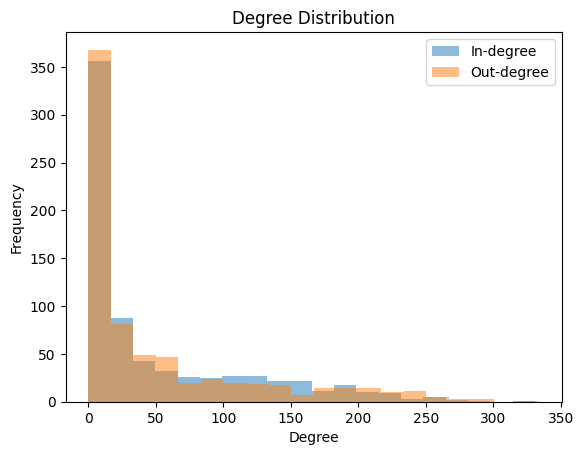


Hubs (airports above the 90th percentile):

Top 10 busiest routes by passenger flow:


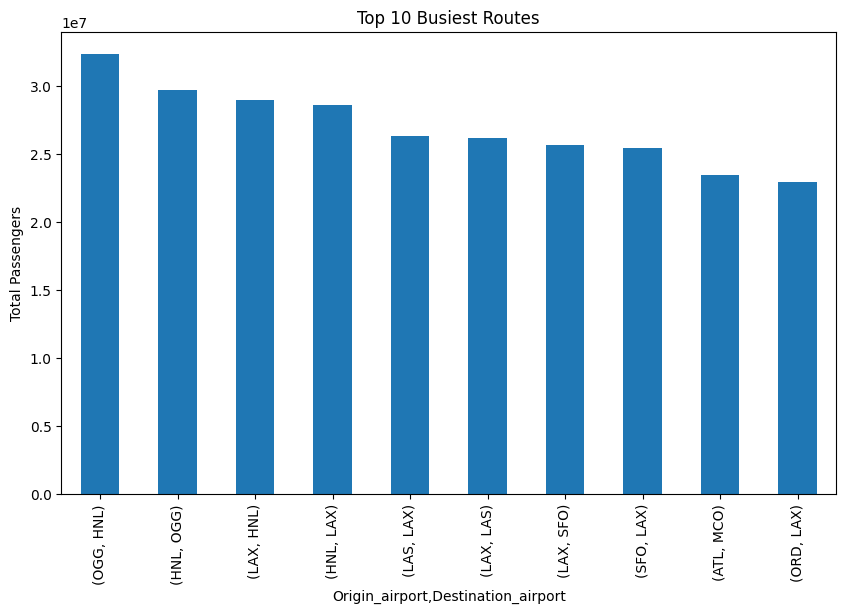


Top 10 routes by passenger efficiency:


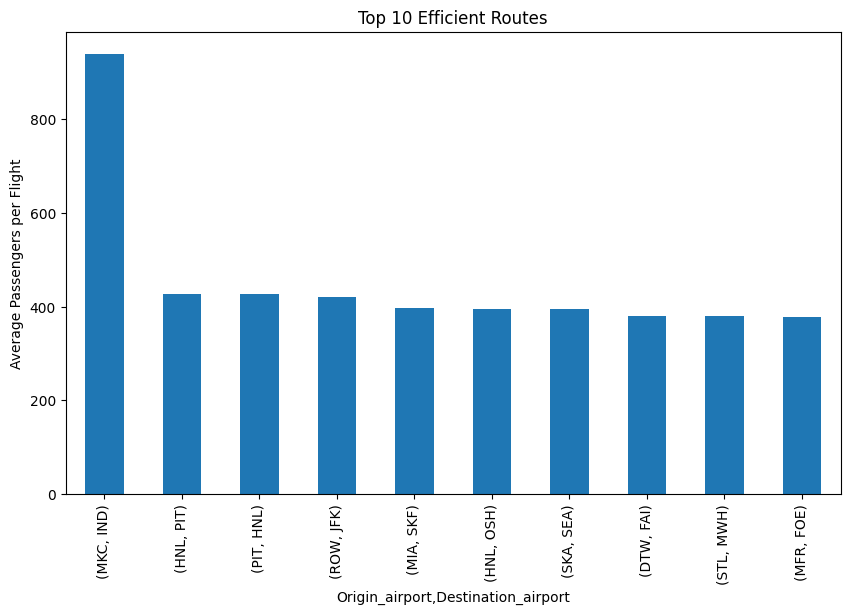

,Hub Airports
0,SEA
1,PDX
2,SFO
3,LAX
4,FLL


In [2]:
# Load the updated data
filepath2 = 'updated_file.csv'  
flight_network, flight_data = load_flight_network(filepath2)  

# Step 2: Analyze the flight network
analysis_results = analyze_graph_features(flight_network, flight_data)  # Pass the DataFrame here

# Step 3: Summarize the analysis
hubs_df = summarize_graph_features(flight_network, analysis_results)

hubs_df.head()


In [ ]:
# Step 4: Create an interactive map
create_interactive_map(flight_data, analysis_results['passenger_flow'])
